In [14]:
from coffea.analysis_tools import PackedSelection
from coffea.lookup_tools.correctionlib_wrapper import correctionlib_wrapper
from coffea.nanoevents import NanoEventsFactory
import correctionlib
import dask
import dask_awkward as dak
import hist.dask
import numpy as np
import dask
import awkward as ak
import os
import urllib

In [ ]:
ttbar_file = "https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0000.root"

# download for subsequent use
local_file_name = "ttbar__nominal.root"
if not os.path.exists(local_file_name):
    urllib.request.urlretrieve(ttbar_file, filename=local_file_name)

In [2]:
fileset = {
    'ttbar__nominal': {
        'files': ['ttbar__nominal.root'],
        'metadata': {'process': 'ttbar',
                     'variation': 'nominal',
                     'nevts': 1334428,
                     'xsec': 729.84
                    }
    },
}

In [3]:
def rand_gauss(item):
    randomstate = np.random.Generator(np.random.PCG64())

    def getfunction(layout, depth, **kwargs):
        if isinstance(layout, ak.contents.NumpyArray):
            return ak.contents.NumpyArray(randomstate.normal(loc=1.0, scale=0.05, size=len(layout)).astype(np.float32))
        return None

    out = ak.transform(getfunction, ak.typetracer.length_zero_if_typetracer(item), behavior=item.behavior)
    if ak.backend(item) == "typetracer":
        out = ak.Array(out.layout.to_typetracer(forget_length=True), behavior=out.behavior)

    assert out is not None
    return out

def jet_pt_resolution(pt):
    # normal distribution with 5% variations, shape matches jets
    resolution_variation = dak.map_partitions(rand_gauss, pt)
    
    return resolution_variation

In [4]:
with dask.config.set({"awkward.compute-unknown-meta": False,
                      "awkward.optimization.enabled": False}):
    
    events = NanoEventsFactory.from_root(
        {fileset["ttbar__nominal"]["files"][0]: "Events"}, 
         permit_dask=True,
    ).events()
        
    # initialize histogam
    histogram = (
        hist.dask.Hist.new.Reg(25, 50, 550, name="observable", label="observable [GeV]")
        .StrCat(["4j1b", "4j2b"], name="region", label="Region")
        .StrCat([], name="process", label="Process", growth=True)
        .StrCat([], name="variation", label="Systematic variation", growth=True)
        .Weight()
    )
    
    xsec_weight = (396.87 + 332.97) * 3378 / 1191997
    
    events["pt_scale_up"] = 1.03
    events["pt_res_up"] = jet_pt_resolution(events.Jet.pt)
    syst_variations = ["nominal"]
    jet_kinematic_systs = ["pt_scale_up", "pt_res_up"]
    event_systs = [f"btag_var_{i}" for i in range(4)]
    syst_variations.extend(jet_kinematic_systs)
    syst_variations.extend(event_systs)
    
    cset = correctionlib.CorrectionSet.from_file("corrections.json")
    
    
    for syst_var in syst_variations:

        ### event selection
        elecs = events.Electron
        muons = events.Muon
        jets = events.Jet
        evtnum = events.event
        if syst_var in jet_kinematic_systs:
            jets["pt"] = jets.pt * events[syst_var]

        electron_reqs = ((elecs.pt > 30) & (np.abs(elecs.eta) < 2.1) 
                         & (elecs.cutBased == 4) & (elecs.sip3d < 4))
        muon_reqs = ((muons.pt > 30) & (np.abs(muons.eta) < 2.1) & (muons.tightId) 
                     & (muons.sip3d < 4) &(muons.pfRelIso04_all < 0.15))
        jet_reqs = (jets.pt > 30) & (np.abs(jets.eta) < 2.4) & (jets.isTightLeptonVeto)

        # Only keep objects that pass our requirements
        elecs = elecs[electron_reqs]
        muons = muons[muon_reqs]
        jets = jets[jet_reqs]
        
        B_TAG_THRESHOLD = 0.5

        ######### Store boolean masks with PackedSelection ##########
        selections = PackedSelection()
        # Basic selection criteria
        selections.add("exactly_1l", (dak.num(elecs) + dak.num(muons)) == 1)
        selections.add("atleast_4j", dak.num(jets) >= 4)
        selections.add("exactly_1b", dak.sum(jets.btagCSVV2 >= B_TAG_THRESHOLD, axis=1) == 1)
        selections.add("atleast_2b", dak.sum(jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) >= 2)
        # Complex selection criteria

        selections.add("4j1b", selections.all("exactly_1l", "atleast_4j", "exactly_1b"))
        selections.add("4j2b", selections.all("exactly_1l", "atleast_4j", "atleast_2b"))
        
        for region in ["4j1b", "4j2b"]:
            
            region_selection = selections.all(region)
            region_jets = jets[region_selection]
            region_elecs = elecs[region_selection]
            region_muons = muons[region_selection]
            region_evtnum = evtnum[region_selection]
            region_weights = dak.full_like(region_evtnum, xsec_weight)
            

            if region == "4j1b":
                observable = dak.sum(region_jets.pt, axis=-1)

            elif region == "4j2b":

                # reconstruct hadronic top as bjj system with largest pT
                trijet = dak.combinations(region_jets, 3, fields=["j1", "j2", "j3"])  # trijet candidates
                trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # calculate four-momentum of tri-jet system
                trijet["max_btag"] = np.maximum(trijet.j1.btagCSVV2, np.maximum(trijet.j2.btagCSVV2, trijet.j3.btagCSVV2))
                trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # at least one-btag in trijet candidates
                # pick trijet candidate with largest pT and calculate mass of system
                trijet_mass = trijet["p4"][dak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
                observable = dak.flatten(trijet_mass)


            syst_var_name = f"{syst_var}"
            # Break up the filling into event weight systematics and object variation systematics
            if syst_var in event_systs:

                for i_dir, direction in enumerate(["up", "down"]):
                    # Should be an event weight systematic with an up/down variation
                    if syst_var.startswith("btag_var"):
                        i_jet = int(syst_var.rsplit("_",1)[-1])   # Kind of fragile
                        wrap_c = correctionlib_wrapper(cset["event_systematics"])
                        wgt_variation = wrap_c("btag_var", direction, region_jets.pt[:,i_jet])
                        # wgt_variation = cset["event_systematics"].evaluate("btag_var", direction, region_jets.pt[:,i_jet])
                    elif syst_var == "scale_var":
                        # The pt array is only used to make sure the output array has the correct shape
                        wrap_c = correctionlib_wrapper(cset["event_systematics"])
                        wgt_variation = wrap_c("scale_var", direction, region_jets.pt[:,0])
                        # wgt_variation = cset["event_systematics"].evaluate("scale_var", direction, region_jets.pt[:,0])
                    syst_var_name = f"{syst_var}_{direction}"
                    histogram.fill(
                        observable=observable, region=region, process="ttbar",
                        variation=syst_var_name, weight=region_weights * wgt_variation
                    )

            else:
                # Should either be 'nominal' or an object variation systematic
                histogram.fill(
                    observable=observable, region=region, process="ttbar",
                    variation=syst_var, weight=region_weights
                )

/Users/elmaka8700/Documents/coffea/src/coffea/nanoevents/schemas/nanoaod.py:215: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/Users/elmaka8700/Documents/coffea/src/coffea/nanoevents/schemas/nanoaod.py:215: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(


In [5]:
with dask.config.set({"awkward.optimization.enabled": False, "awkward.compute-unknown-meta": False}):
    histogram_computed = histogram.compute()

In [6]:
histogram_computed

Hist(
  Regular(25, 50, 550, name='observable', label='observable [GeV]'),
  StrCategory(['4j1b', '4j2b'], name='region', label='Region'),
  StrCategory(['ttbar'], growth=True, name='process', label='Process'),
  StrCategory(['nominal', 'pt_scale_up', 'pt_res_up', 'btag_var_0_up', 'btag_var_0_down', 'btag_var_1_up', 'btag_var_1_down', 'btag_var_2_up', 'btag_var_2_down', 'btag_var_3_up', 'btag_var_3_down'], growth=True, name='variation', label='Systematic variation'),
  storage=Weight()) # Sum: WeightedSum(value=850506, variance=1.72594e+06) (WeightedSum(value=912312, variance=1.85745e+06) with flow)

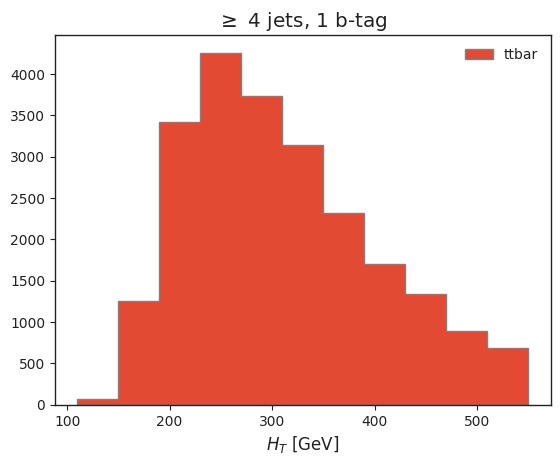

In [7]:
import matplotlib.pyplot as plt
import utils
utils.set_style()

histogram_computed[120j::hist.rebin(2), "4j1b", :, "nominal"].stack("process")[::-1].plot(stack=True, histtype="fill", linewidth=1, edgecolor="grey")
plt.legend(frameon=False)
plt.title("$\geq$ 4 jets, 1 b-tag")
plt.xlabel("$H_T$ [GeV]");

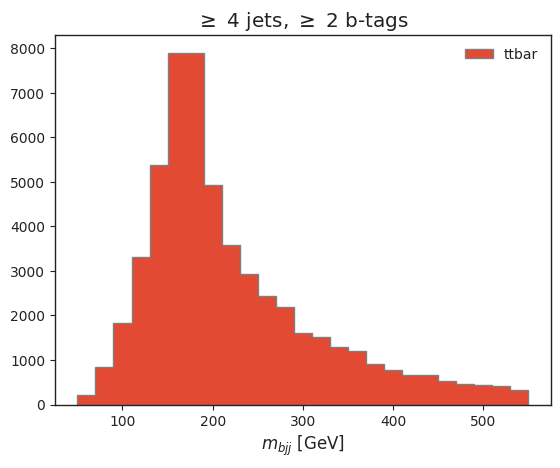

In [8]:
histogram_computed[:, "4j2b", :, "nominal"].stack("process")[::-1].plot(stack=True, histtype="fill", linewidth=1,edgecolor="grey")
plt.legend(frameon=False)
plt.title("$\geq$ 4 jets, $\geq$ 2 b-tags")
plt.xlabel("$m_{bjj}$ [GeV]");

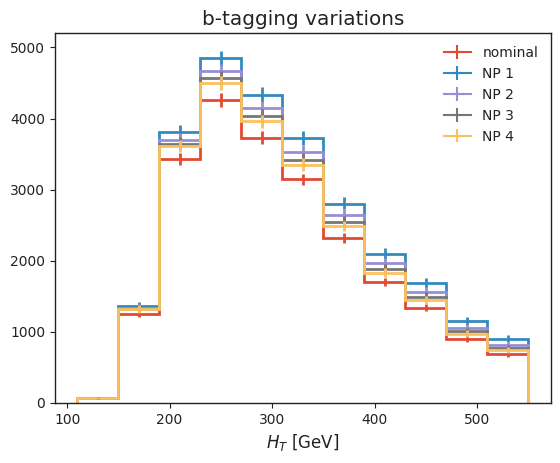

In [9]:
# b-tagging variations
histogram_computed[120j::hist.rebin(2), "4j1b", "ttbar", "nominal"].plot(label="nominal", linewidth=2)
histogram_computed[120j::hist.rebin(2), "4j1b", "ttbar", "btag_var_0_up"].plot(label="NP 1", linewidth=2)
histogram_computed[120j::hist.rebin(2), "4j1b", "ttbar", "btag_var_1_up"].plot(label="NP 2", linewidth=2)
histogram_computed[120j::hist.rebin(2), "4j1b", "ttbar", "btag_var_2_up"].plot(label="NP 3", linewidth=2)
histogram_computed[120j::hist.rebin(2), "4j1b", "ttbar", "btag_var_3_up"].plot(label="NP 4", linewidth=2)
plt.legend(frameon=False)
plt.xlabel("$H_T$ [GeV]")
plt.title("b-tagging variations");

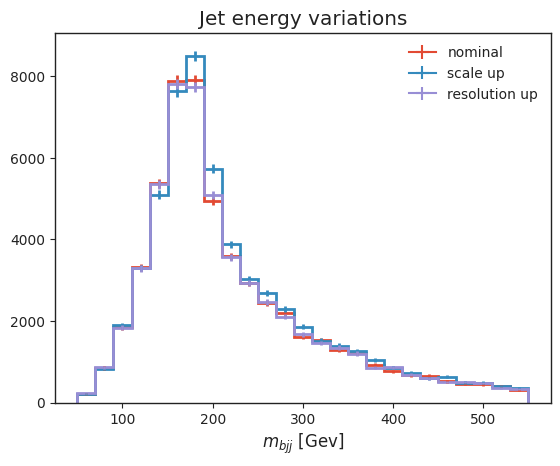

In [10]:
# jet energy scale variations
histogram_computed[:, "4j2b", "ttbar", "nominal"].plot(label="nominal", linewidth=2)
histogram_computed[:, "4j2b", "ttbar", "pt_scale_up"].plot(label="scale up", linewidth=2)
histogram_computed[:, "4j2b", "ttbar", "pt_res_up"].plot(label="resolution up", linewidth=2)
plt.legend(frameon=False)
plt.xlabel("$m_{bjj}$ [Gev]")
plt.title("Jet energy variations");